# Doc2Vec with K-Means
## Reading data from CSV

In [1]:
import pandas as pd
from gensim.models.doc2vec import TaggedDocument
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns

from src.commons.parse_utils import parse_list_column

In [2]:
csv_file = "../../data/arxiv_processed.csv"
data = pd.read_csv(csv_file, sep=";", converters={'Processed Summary': parse_list_column})

In [3]:
data.head()

,ID,Title,Summary,Published,PDF Link,Processed Summary
0,http://arxiv.org/abs/cs/0002002v1,Uniform semantic treatment of default and auto...,We revisit the issue of connections between tw...,2000-02-03T21:44:57Z,http://arxiv.org/pdf/cs/0002002v1,"[revisit, issue, connection, two, leading, for..."
1,http://arxiv.org/abs/cs/0002003v1,On the accuracy and running time of GSAT,Randomized algorithms for deciding satisfiabil...,2000-02-04T12:53:57Z,http://arxiv.org/pdf/cs/0002003v1,"[randomized, algorithm, deciding, satisfiabili..."
2,http://arxiv.org/abs/cs/0002009v1,Syntactic Autonomy: Why There is no Autonomy w...,Two different types of agency are discussed ba...,2000-02-16T18:09:20Z,http://arxiv.org/pdf/cs/0002009v1,"[two, different, type, agency, discussed, base..."
3,http://arxiv.org/abs/cs/0003008v1,Consistency Management of Normal Logic Program...,This paper presents a method of computing a re...,2000-03-05T10:29:03Z,http://arxiv.org/pdf/cs/0003008v1,"[paper, present, method, computing, revision, ..."
4,http://arxiv.org/abs/cs/0003016v1,Abductive and Consistency-Based Diagnosis Revi...,Diagnostic reasoning has been characterized lo...,2000-03-07T11:39:53Z,http://arxiv.org/pdf/cs/0003016v1,"[diagnostic, reasoning, characterized, logical..."


## Training Doc2Vec model

In [4]:
from gensim.models import Doc2Vec

tagged_data = [TaggedDocument(words=row['Processed Summary'], tags=[str(index)]) for index, row in data.iterrows()]

model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [38]:
model.save('topic_model')

## Clustering with K-Means

In [5]:
kmeans = KMeans(n_clusters=35, init='k-means++', max_iter=300, n_init=10, random_state=0)

In [6]:
y_kmeans = kmeans.fit_predict(model.dv.vectors)

In [7]:
data['Topic'] = y_kmeans

In [8]:
data.head()

,ID,Title,Summary,Published,PDF Link,Processed Summary,Topic
0,http://arxiv.org/abs/cs/0002002v1,Uniform semantic treatment of default and auto...,We revisit the issue of connections between tw...,2000-02-03T21:44:57Z,http://arxiv.org/pdf/cs/0002002v1,"[revisit, issue, connection, two, leading, for...",8
1,http://arxiv.org/abs/cs/0002003v1,On the accuracy and running time of GSAT,Randomized algorithms for deciding satisfiabil...,2000-02-04T12:53:57Z,http://arxiv.org/pdf/cs/0002003v1,"[randomized, algorithm, deciding, satisfiabili...",8
2,http://arxiv.org/abs/cs/0002009v1,Syntactic Autonomy: Why There is no Autonomy w...,Two different types of agency are discussed ba...,2000-02-16T18:09:20Z,http://arxiv.org/pdf/cs/0002009v1,"[two, different, type, agency, discussed, base...",12
3,http://arxiv.org/abs/cs/0003008v1,Consistency Management of Normal Logic Program...,This paper presents a method of computing a re...,2000-03-05T10:29:03Z,http://arxiv.org/pdf/cs/0003008v1,"[paper, present, method, computing, revision, ...",8
4,http://arxiv.org/abs/cs/0003016v1,Abductive and Consistency-Based Diagnosis Revi...,Diagnostic reasoning has been characterized lo...,2000-03-07T11:39:53Z,http://arxiv.org/pdf/cs/0003016v1,"[diagnostic, reasoning, characterized, logical...",8


### Visualizing clusters

In [9]:
X_embedded = TSNE(n_components=2).fit_transform(model.dv.vectors)

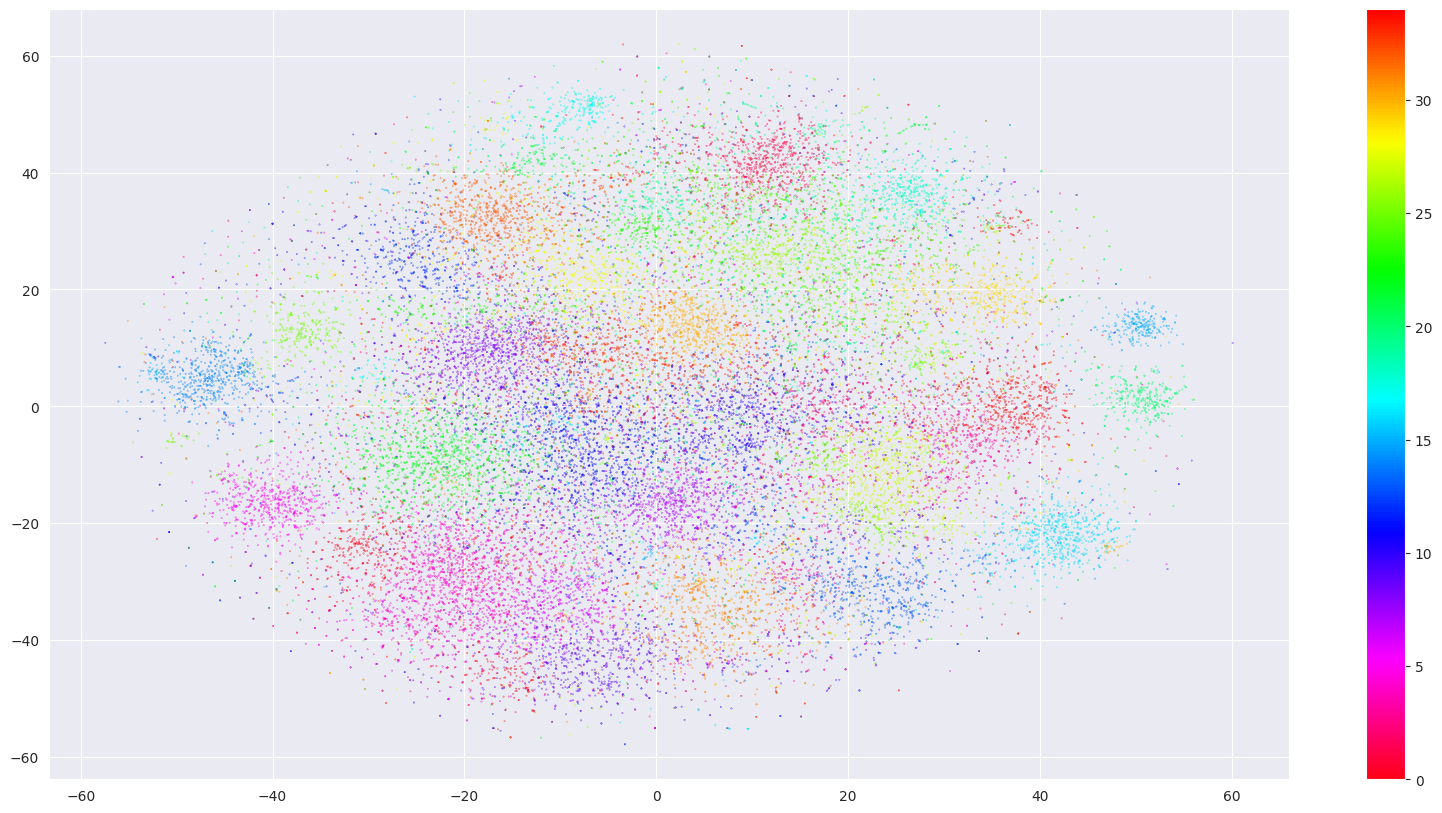

In [10]:
plt.figure(figsize=(20, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_kmeans, s=0.05, cmap='hsv_r')
plt.colorbar()
plt.show()

#### Topic 0 exploration
##### Visualization

In [11]:
topic1_embedded = X_embedded[y_kmeans == 0]

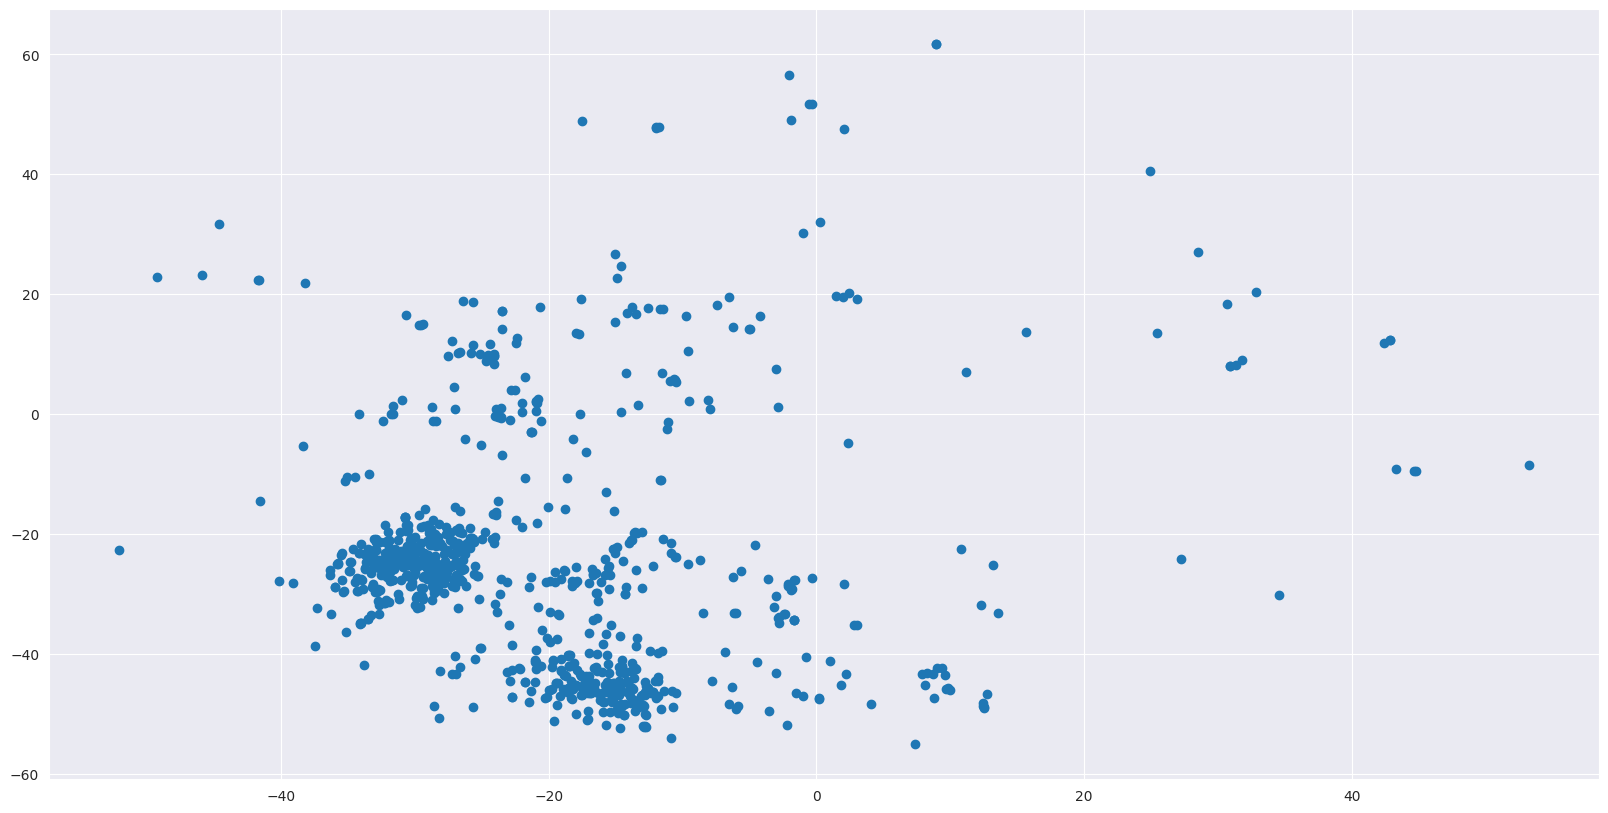

In [12]:
plt.figure(figsize=(20, 10))
plt.scatter(topic1_embedded[:, 0], topic1_embedded[:, 1])
plt.show()

##### Words

In [13]:
processed_summaries = []
for summary in data['Processed Summary']:
    processed_summaries.append(' '.join(summary))

docs_df = pd.DataFrame(processed_summaries, columns=["Doc"])
docs_df['Topic'] = y_kmeans
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [14]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [15]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [16]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)

,Topic,Size
4,4,1716
22,22,1494
11,11,1441
28,28,1419
10,10,1299
27,27,1296
33,33,1257
8,8,1252
24,24,1217
7,7,1107


In [17]:
# topic 0 size
topic_sizes[topic_sizes['Topic'] == 0]

,Topic,Size
0,0,871


In [18]:
top10_words_topic0 =  [i[0] for i in  top_n_words[0][:10]]
print(top10_words_topic0)

['planning', 'plan', 'action', 'planner', 'state', 'policy', 'search', 'goal', 'domain', 'heuristic']


Some 10 examples summaries from cluster 0:

In [19]:
topic0_docs = data[data['Topic'] == 0]

In [20]:
for index, row in topic0_docs.head(10).iterrows():
    print(f"Document ID: {row['ID']}")
    print(f"Title: {row['Title']}")
    print(f"Summary: {row['Summary']}")
    print(f"Topic: {row['Topic']}")
    print("-" * 80)

Document ID: http://arxiv.org/abs/cs/0003032v1
Title: cc-Golog: Towards More Realistic Logic-Based Robot Controllers
Summary: High-level robot controllers in realistic domains typically deal with processes which operate concurrently, change the world continuously, and where the execution of actions is event-driven as in ``charge the batteries as soon as the voltage level is low''. While non-logic-based robot control languages are well suited to express such scenarios, they fare poorly when it comes to projecting, in a conspicuous way, how the world evolves when actions are executed. On the other hand, a logic-based control language like \congolog, based on the situation calculus, is well-suited for the latter. However, it has problems expressing event-driven behavior. In this paper, we show how these problems can be overcome by first extending the situation calculus to support continuous change and event-driven behavior and then presenting \ccgolog, a variant of \congolog which is base

In [21]:
top10_words_topic10 = [i[0] for i in  top_n_words[10][:10]]
print(top10_words_topic10)

['label', 'sample', 'class', 'domain', 'training', 'target', 'distribution', 'datasets', 'classification', 'classifier']


In [22]:
topic10_docs = data[data['Topic'] == 10]

In [23]:
for index, row in topic10_docs.head(10).iterrows():
    print(f"Document ID: {row['ID']}")
    print(f"Title: {row['Title']}")
    print(f"Summary: {row['Summary']}")
    print(f"Topic: {row['Topic']}")
    print("-" * 80)

Document ID: http://arxiv.org/abs/cs/0605123v1
Title: Classification of Ordinal Data
Summary: Classification of ordinal data is one of the most important tasks of relation learning. In this thesis a novel framework for ordered classes is proposed. The technique reduces the problem of classifying ordered classes to the standard two-class problem. The introduced method is then mapped into support vector machines and neural networks. Compared with a well-known approach using pairwise objects as training samples, the new algorithm has a reduced complexity and training time. A second novel model, the unimodal model, is also introduced and a parametric version is mapped into neural networks. Several case studies are presented to assert the validity of the proposed models.
Topic: 10
--------------------------------------------------------------------------------
Document ID: http://arxiv.org/abs/0704.3905v1
Title: Ensemble Learning for Free with Evolutionary Algorithms ?
Summary: Evolutionary

In [24]:
for i in range(35):
    print(f"Topic {i} size: {topic_sizes[topic_sizes['Topic'] == i]['Size'].values[0]}")
    print(f"Top 10 words: {[i[0] for i in  top_n_words[i][:10]]}")

Topic 0 size: 871
Top 10 words: ['planning', 'plan', 'action', 'planner', 'state', 'policy', 'search', 'goal', 'domain', 'heuristic']
Topic 1 size: 951
Top 10 words: ['language', 'multilingual', 'translation', 'english', 'word', 'corpus', 'sentence', 'nlp', 'text', 'llm']
Topic 2 size: 1063
Top 10 words: ['representation', 'feature', 'classification', 'clustering', 'contrastive', 'space', 'modality', 'datasets', 'information', 'embeddings']
Topic 3 size: 1037
Top 10 words: ['detection', 'image', 'classification', 'accuracy', 'dataset', 'deep', 'fault', 'using', 'used', 'sensor']
Topic 4 size: 1716
Top 10 words: ['policy', 'rl', 'reward', 'reinforcement', 'offline', 'environment', 'state', 'action', 'function', 'exploration']
Topic 5 size: 703
Top 10 words: ['game', 'player', 'agent', 'playing', 'level', 'strategy', 'play', 'chess', 'opponent', 'ai']
Topic 6 size: 1045
Top 10 words: ['agent', 'environment', 'reinforcement', 'action', 'reward', 'goal', 'policy', 'behavior', 'rl', 'commun

### Topic Trend by year


In [25]:
data['Year'] = pd.to_datetime(data['Published']).dt.year

In [26]:
topic_trend = data.groupby(['Year', 'Topic']).size().reset_index(name='Count')

In [27]:
topic_trend.head()

,Year,Topic,Count
0,2000,0,2
1,2000,1,1
2,2000,2,1
3,2000,3,1
4,2000,6,2


In [28]:
topic_trend_pivot = topic_trend.pivot(index='Year', columns='Topic', values='Count').fillna(0)

In [29]:
topic_trend_pivot.head()

Topic,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
Year,,,,,,,,,,,,,,,,,,,,,
2000,2.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,22.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0
2002,3.0,0.0,2.0,0.0,0.0,1.0,3.0,0.0,34.0,1.0,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,3.0,0.0
2003,3.0,2.0,4.0,3.0,0.0,1.0,1.0,2.0,23.0,1.0,...,0.0,0.0,1.0,5.0,0.0,0.0,1.0,0.0,10.0,0.0
2004,2.0,2.0,4.0,6.0,1.0,1.0,3.0,2.0,15.0,2.0,...,0.0,1.0,3.0,4.0,0.0,0.0,3.0,0.0,7.0,0.0


Normalize it by number of articles in year

In [30]:
# Normalize topic_trend_pivot by number of articles in year
total_articles_per_year = topic_trend_pivot.sum(axis=1)

topic_trend_pivot_normalized = topic_trend_pivot.div(total_articles_per_year, axis=0)

topic_trend_pivot_normalized.head()

Topic,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
Year,,,,,,,,,,,,,,,,,,,,,
2000,0.054054,0.027027,0.027027,0.027027,0.000000,0.000000,0.054054,0.000000,0.594595,0.000000,...,0.0,0.027027,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
2001,0.030303,0.060606,0.030303,0.000000,0.000000,0.030303,0.000000,0.000000,0.181818,0.000000,...,0.0,0.000000,0.000000,0.151515,0.0,0.0,0.030303,0.030303,0.000000,0.0
2002,0.044118,0.000000,0.029412,0.000000,0.000000,0.014706,0.044118,0.000000,0.500000,0.014706,...,0.0,0.000000,0.000000,0.029412,0.0,0.0,0.014706,0.000000,0.044118,0.0
2003,0.038462,0.025641,0.051282,0.038462,0.000000,0.012821,0.012821,0.025641,0.294872,0.012821,...,0.0,0.000000,0.012821,0.064103,0.0,0.0,0.012821,0.000000,0.128205,0.0
2004,0.019417,0.019417,0.038835,0.058252,0.009709,0.009709,0.029126,0.019417,0.145631,0.019417,...,0.0,0.009709,0.029126,0.038835,0.0,0.0,0.029126,0.000000,0.067961,0.0


In [31]:
from sklearn.preprocessing import MinMaxScaler

# Normalize topic_trend_pivot_normalized to 0-1 range
scaler = MinMaxScaler()
topic_trend_pivot_normalized_0_1 = pd.DataFrame(scaler.fit_transform(topic_trend_pivot_normalized),
                                                index=topic_trend_pivot_normalized.index,
                                                columns=topic_trend_pivot_normalized.columns)

topic_trend_pivot_normalized_0_1.head()

Topic,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
Year,,,,,,,,,,,,,,,,,,,,,
2000,0.412181,0.445946,0.306306,0.232432,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.0,0.783140,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
2001,0.201809,1.000000,0.377778,0.000000,0.000000,0.491717,0.000000,0.000000,0.288632,0.000000,...,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.643939,0.719488,0.000000,0.0
2002,0.324170,0.000000,0.358333,0.000000,0.000000,0.238627,0.816176,0.000000,0.836978,0.380788,...,0.0,0.000000,0.000000,0.194118,0.0,0.0,0.312500,0.000000,0.237379,0.0
2003,0.274072,0.423077,0.835470,0.330769,0.000000,0.208034,0.237179,0.630789,0.483466,0.331969,...,0.0,0.000000,0.264902,0.423077,0.0,0.0,0.272436,0.000000,0.689820,0.0
2004,0.105391,0.320388,0.563916,0.500971,0.119405,0.157540,0.538835,0.477685,0.226268,0.502789,...,0.0,0.281322,0.601817,0.256311,0.0,0.0,0.618932,0.000000,0.365672,0.0


<Axes: xlabel='Year'>

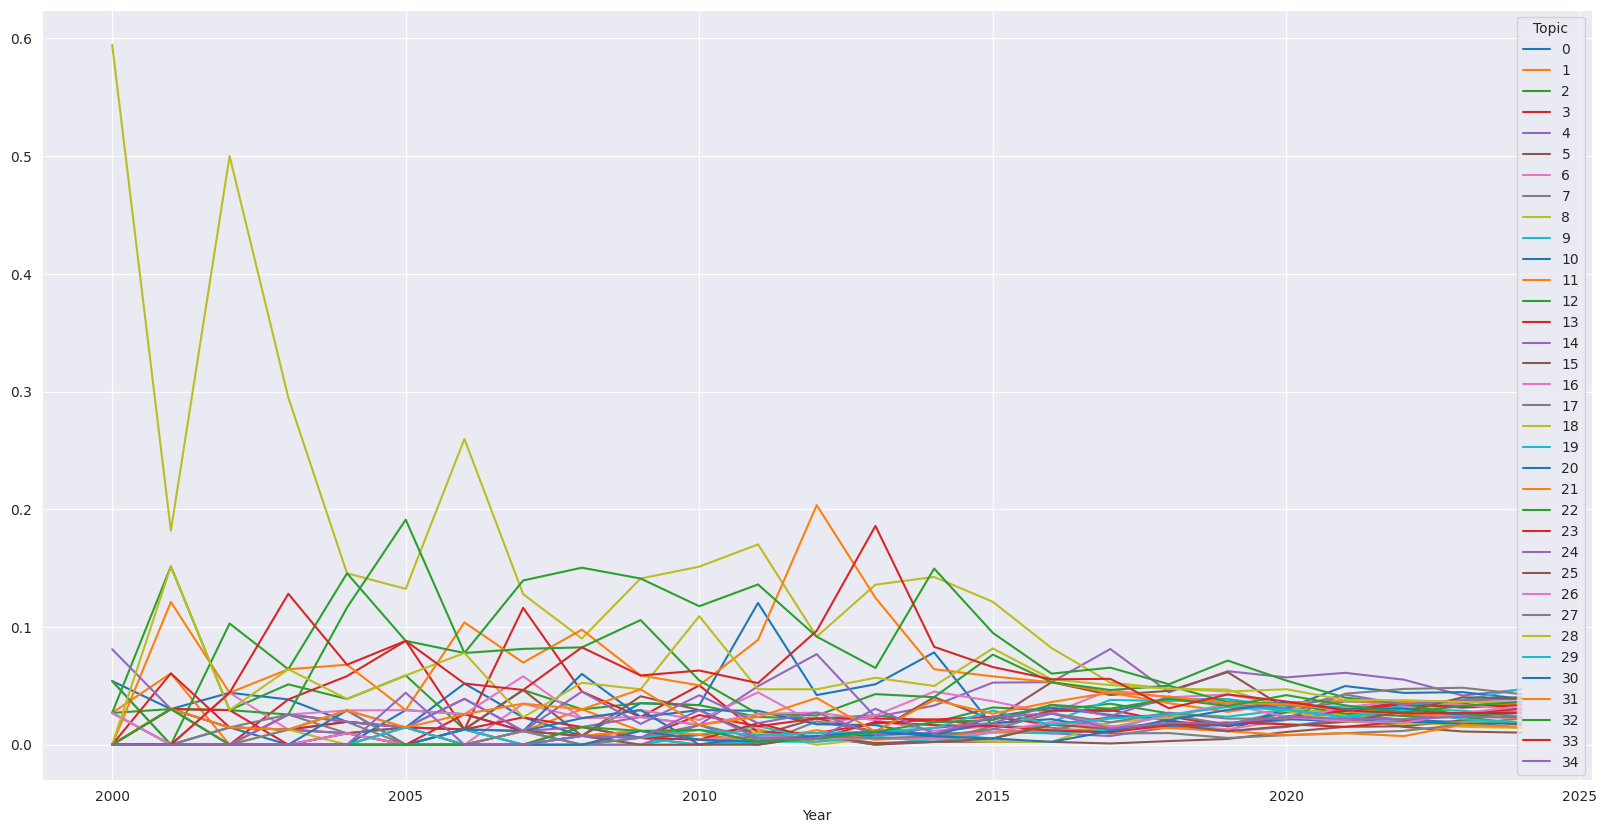

In [32]:
topic_trend_pivot_normalized.plot(kind='line', figsize=(20, 10))

<Axes: xlabel='Year'>

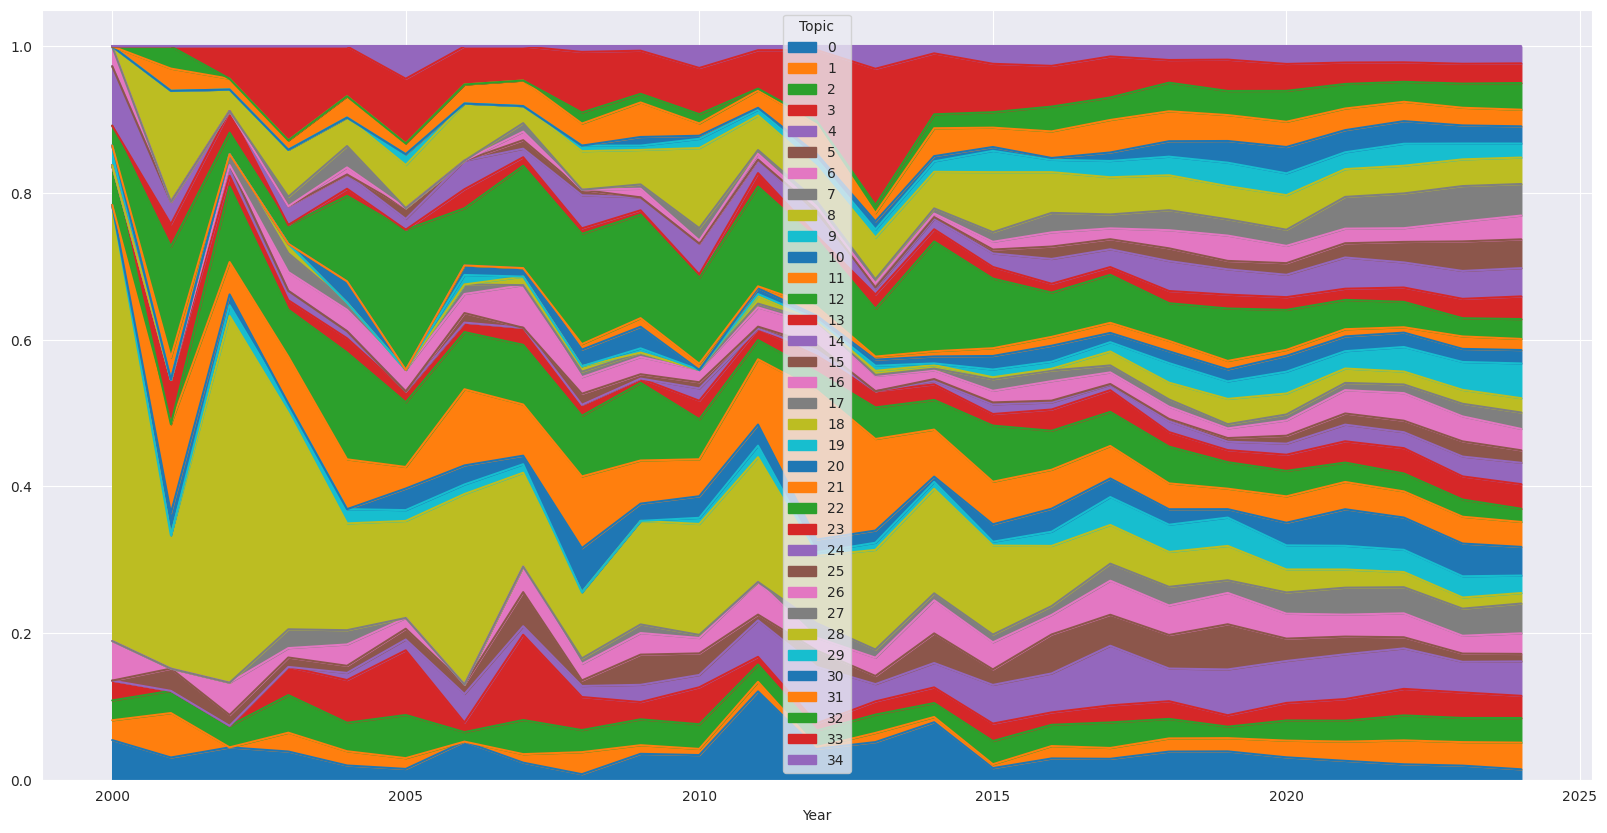

In [33]:
topic_trend_pivot_normalized.plot(kind='area', figsize=(20, 10))

<Axes: xlabel='Year'>

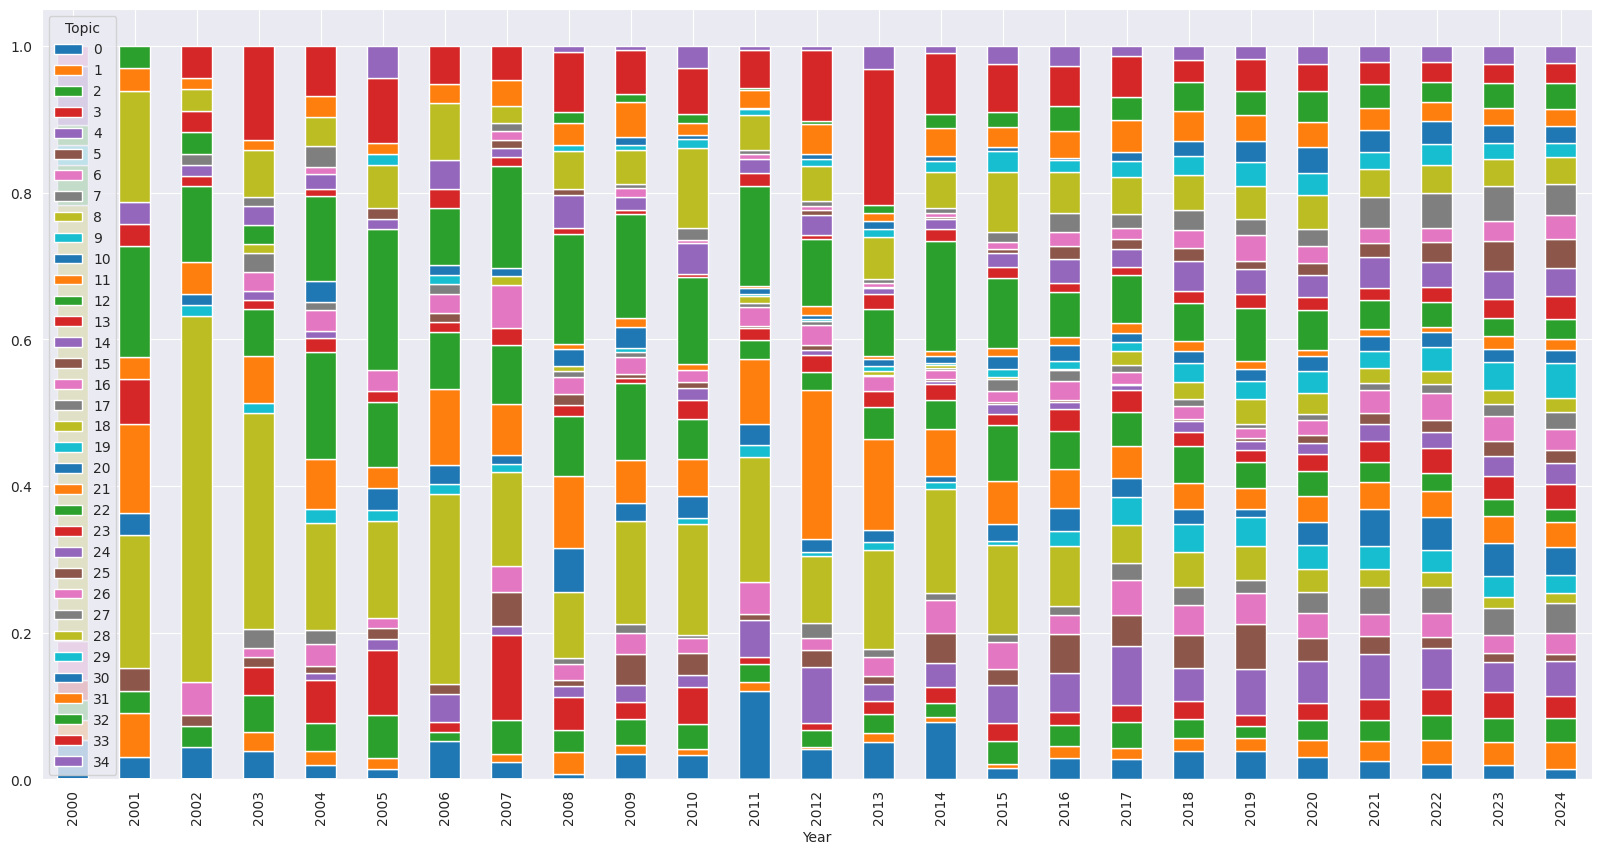

In [34]:
topic_trend_pivot_normalized.plot(kind='bar', stacked=True, figsize=(20, 10))

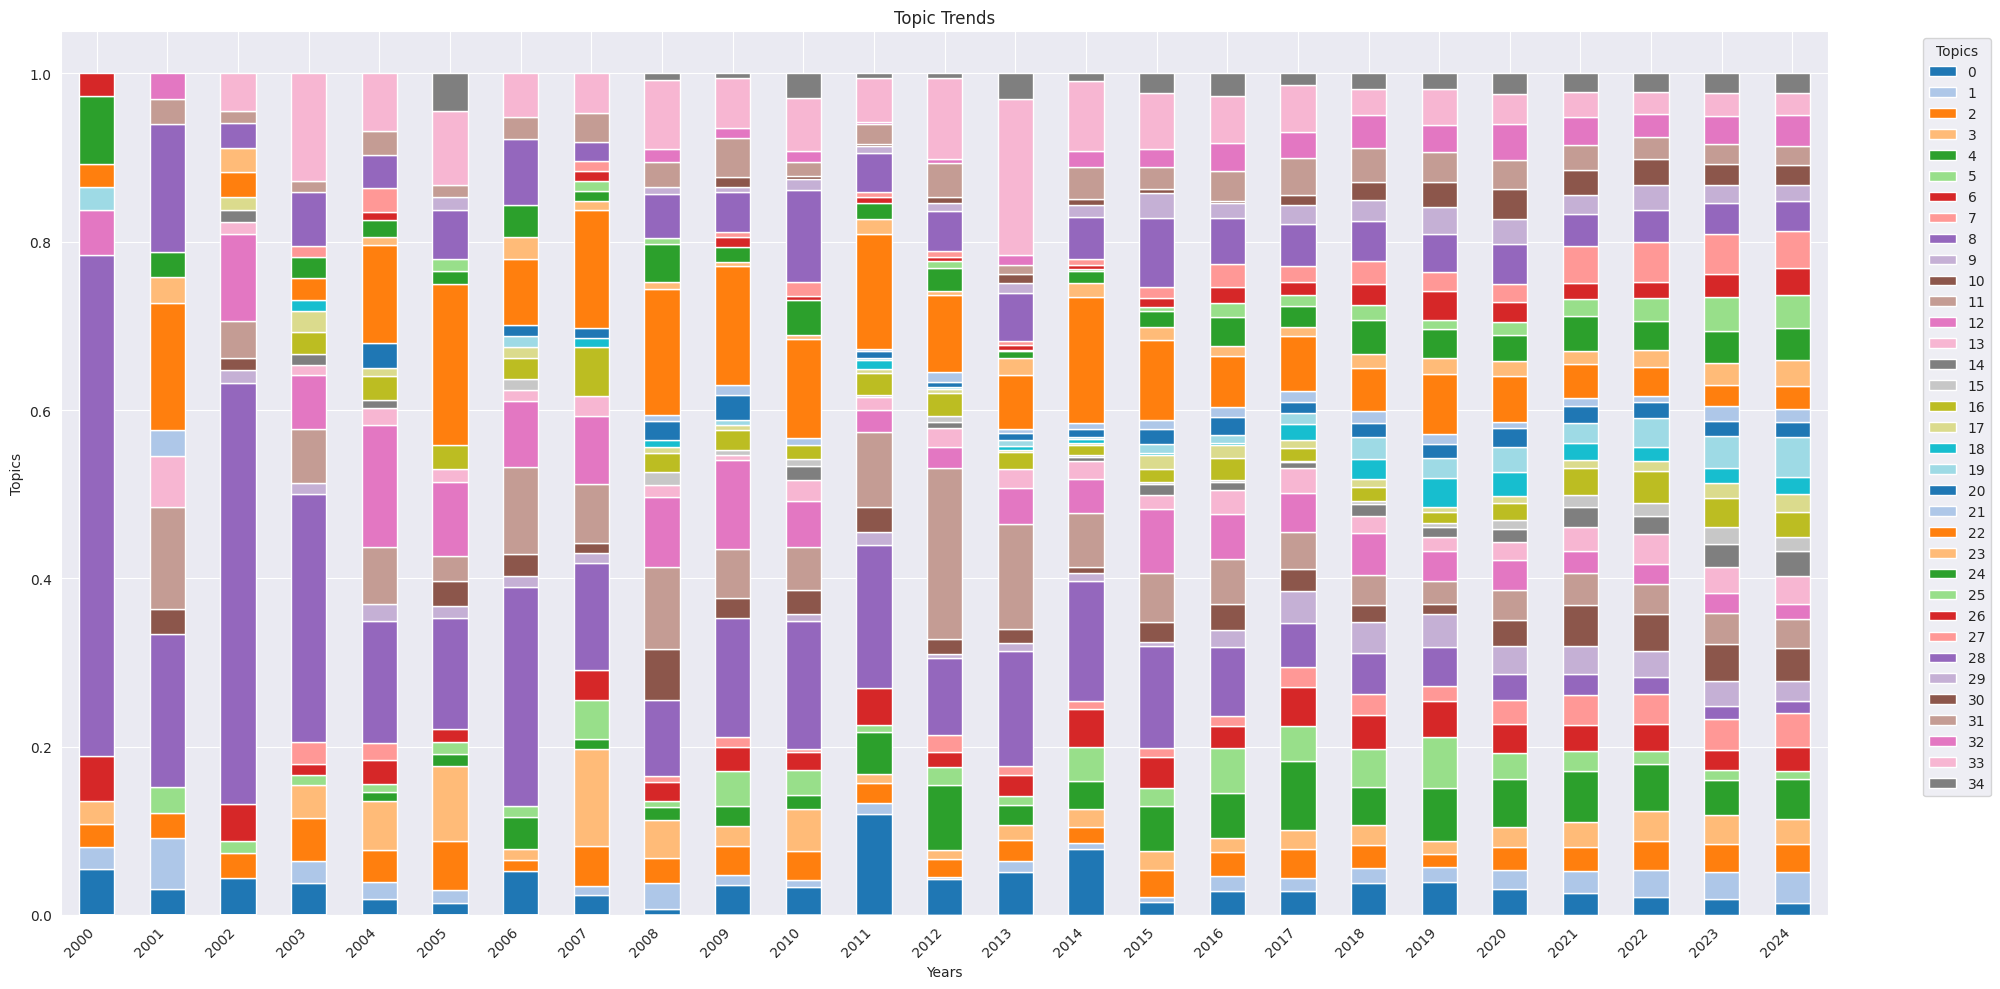

In [35]:
num_topics = len(topic_trend_pivot_normalized.columns)
palette = sns.color_palette("tab20", n_colors=num_topics)

# Plot
fig, ax = plt.subplots(figsize=(max(20, num_topics * 0.5), 10))  # Adjust width dynamically
topic_trend_pivot_normalized.plot(
    kind='bar',
    stacked=True,
    figsize=(20, 10),
    ax=ax,
    color=palette
)

# Adjust legend
ax.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')

# Improve readability of the x-axis labels
plt.xticks(rotation=45, ha='right')

# Add title and labels
plt.title("Topic Trends")
plt.xlabel("Years")
plt.ylabel("Topics")

plt.tight_layout()
plt.show()

<Axes: xlabel='Year'>

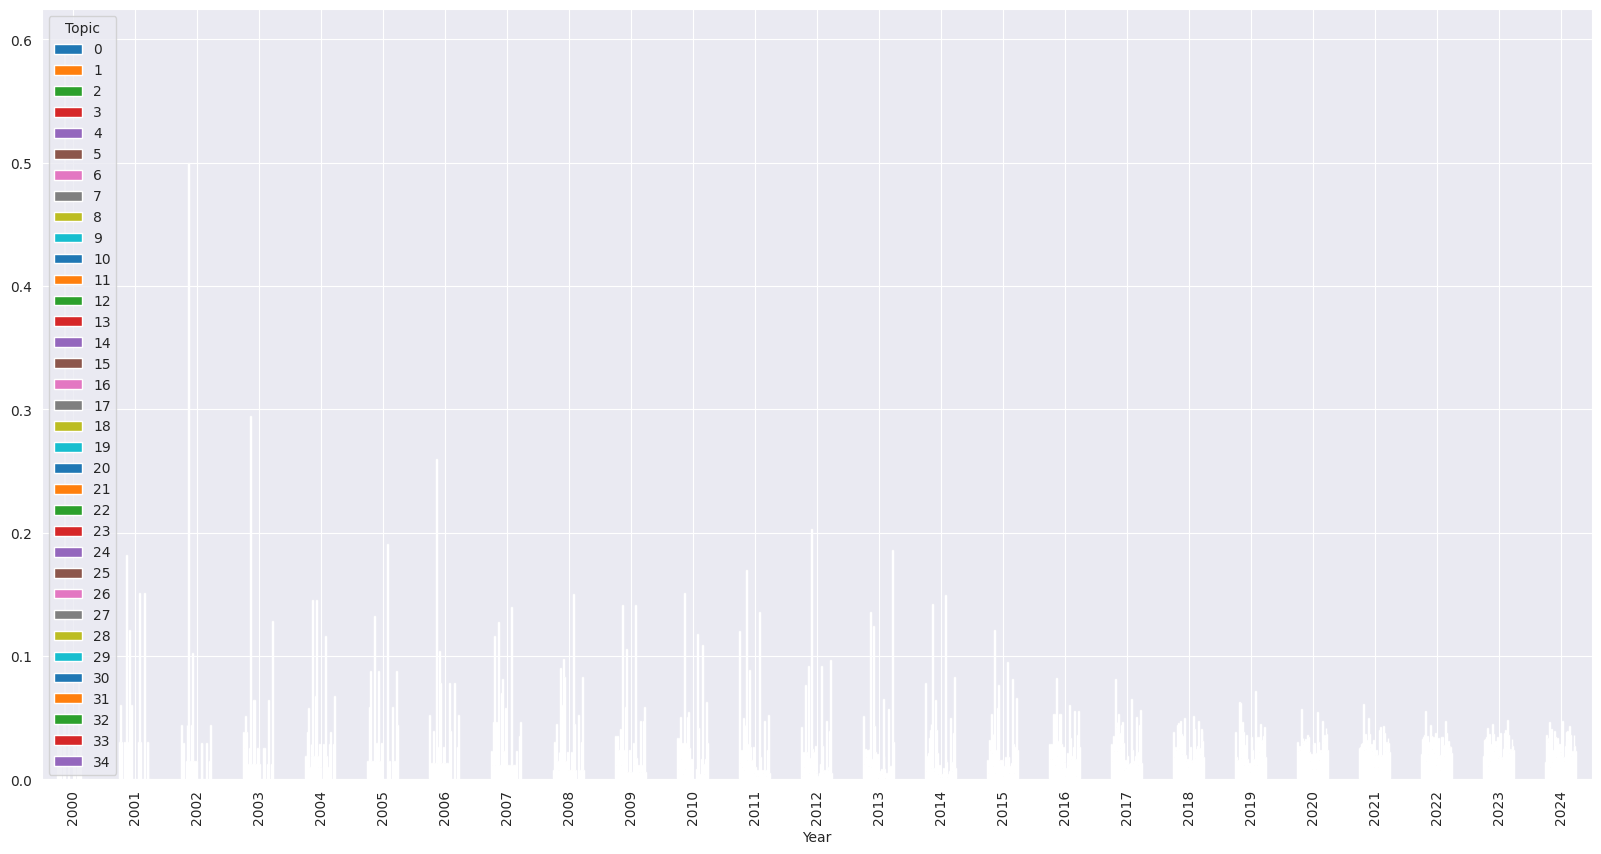

In [36]:
topic_trend_pivot_normalized.plot(kind='bar', figsize=(20, 10))

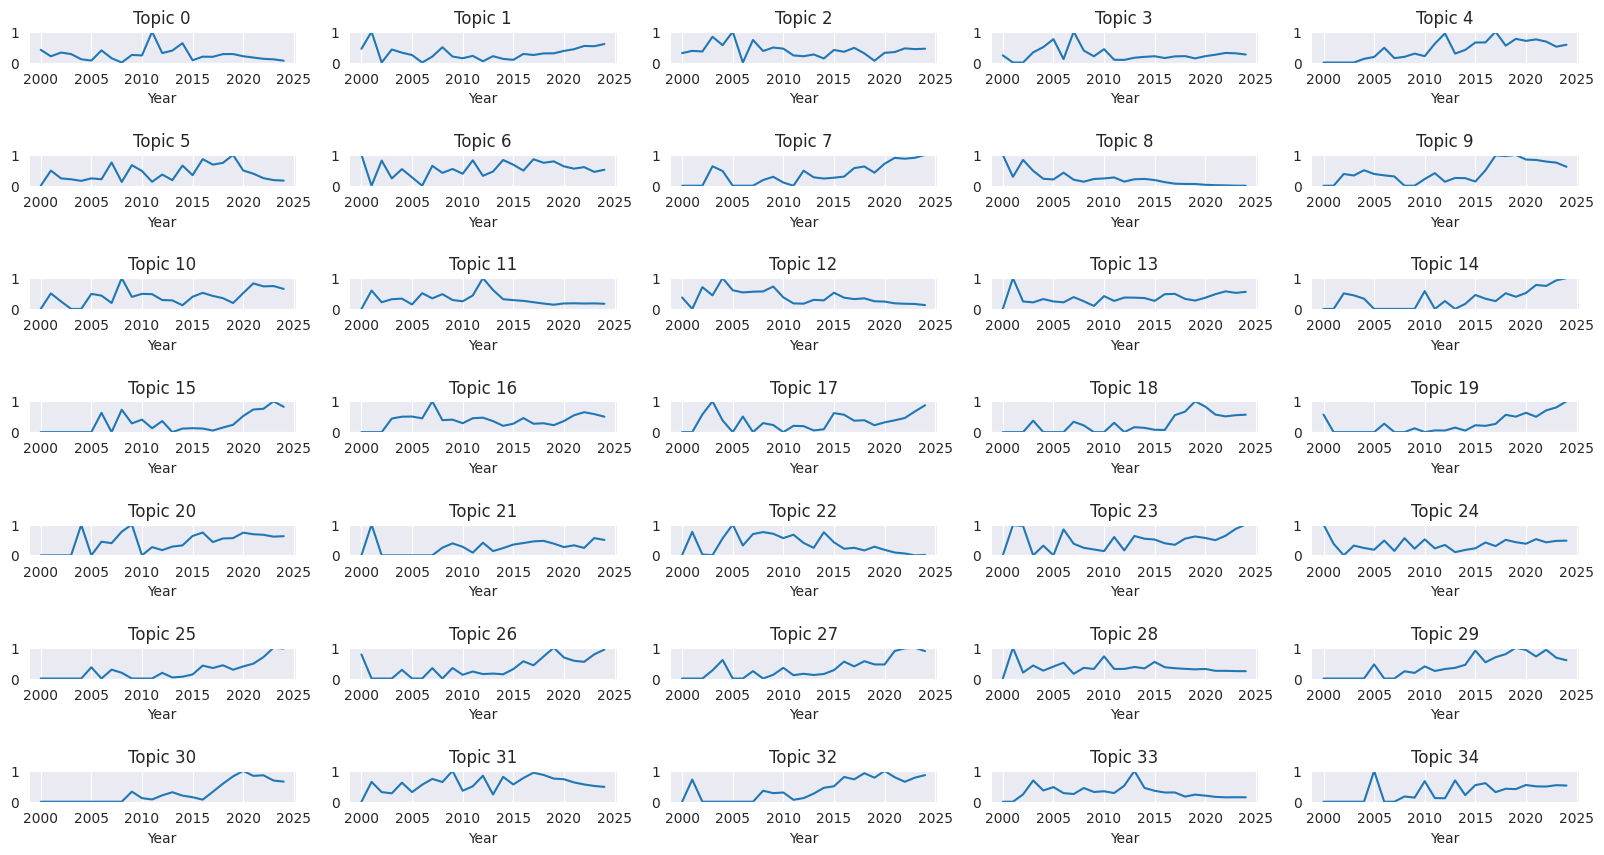

In [37]:
y_min = topic_trend_pivot_normalized_0_1.min().min()
y_max = topic_trend_pivot_normalized_0_1.max().max()

fig, axs = plt.subplots(7, 5, figsize=(20, 10))
for i in range(35):
    topic_trend_pivot_normalized_0_1[i].plot(ax=axs[i//5, i%5], title=f"Topic {i}")
    axs[i//5, i%5].set_ylim(y_min, y_max)  # Set the same y-axis limits for each subplot

plt.subplots_adjust(hspace=3)  # Adjust the height space between rows
plt.show()

### Metrics

In [27]:
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.evaluation_metrics.diversity_metrics import TopicDiversity, InvertedRBO
from octis.evaluation_metrics.similarity_metrics import PairwiseJaccardSimilarity
from octis.evaluation_metrics.topic_significance_metrics import KL_uniform, KL_vacuous, KL_background

In [22]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30)
top_n_words_list = [top_n_words[i] for i in range(len(top_n_words))]
top_n_words_list = [[tuple[0] for tuple in topic] for topic in top_n_words_list]
top_n_words_list

[['cognitive',
  'intelligence',
  'human',
  'brain',
  'artificial',
  'theory',
  'machine',
  'concept',
  'computational',
  'ai',
  'neural',
  'consciousness',
  'cognition',
  'ability',
  'biological',
  'intelligent',
  'world',
  'computer',
  'memory',
  'mechanism',
  'reasoning',
  'computing',
  'processing',
  'architecture',
  'understanding',
  'symbolic',
  'neuron',
  'structure',
  'evolution',
  'general'],
 ['vehicle',
  'traffic',
  'service',
  'control',
  'scheduling',
  'management',
  'resource',
  'energy',
  'routing',
  'demand',
  'solution',
  'network',
  'transportation',
  'simulation',
  'optimization',
  'time',
  'communication',
  'dynamic',
  'cost',
  'optimal',
  'reinforcement',
  'route',
  'environment',
  'operation',
  'road',
  'algorithm',
  'urban',
  'device',
  'smart',
  'power'],
 ['pruning',
  'architecture',
  'quantization',
  'memory',
  'parameter',
  'layer',
  'neural',
  'training',
  'accuracy',
  'network',
  'weight',
 

In [34]:
# calculate probability that document belongs to topic
centroids = kmeans.cluster_centers_
doc_embeddings = model.dv.vectors

In [35]:
from scipy.spatial.distance import cdist

distances = cdist(doc_embeddings, centroids, 'euclidean')
distances.shape

(34427, 35)

In [36]:
beta = 1.0
weights = np.exp(-beta * distances.T)
weights /= weights.sum(axis=0)

print("N x D Weights Matrix:")
print(weights)

N x D Weights Matrix:
[[0.03709201 0.02542859 0.05122558 ... 0.02384894 0.01693581 0.02119294]
 [0.0168009  0.02543819 0.03144763 ... 0.01885514 0.03281076 0.01874805]
 [0.02286068 0.02692566 0.03023985 ... 0.02667353 0.02741977 0.03594149]
 ...
 [0.01620563 0.02178477 0.01887679 ... 0.01966811 0.03070559 0.10190948]
 [0.01932747 0.01854288 0.01950319 ... 0.018374   0.03085618 0.03280102]
 [0.01899943 0.01881252 0.03510596 ... 0.0271902  0.02565787 0.02075257]]


In [39]:
model_output = dict()
model_output['topics'] = top_n_words_list
model_output['topic-word-matrix'] = tf_idf
model_output["topic-document-matrix"] = weights

In [23]:
from octis.dataset.dataset import Dataset

dataset = Dataset()
dataset.load_custom_dataset_from_folder("../../data/octis")

In [30]:
def calculate_metrics(model_output, dataset, topk=10, verbose=False):
    umass = Coherence(texts=dataset.get_corpus(), topk=topk, measure='u_mass')
    npmi = Coherence(texts=dataset.get_corpus(), topk=topk, measure='c_npmi')
    c_v = Coherence(texts=dataset.get_corpus(), topk=topk, measure='c_v')
    topic_diversity = TopicDiversity(topk=topk)
    inv_rbo = InvertedRBO(topk=topk)
    pairwise_jaccard = PairwiseJaccardSimilarity()
    kl_uniform = KL_uniform()
    kl_vacuous = KL_vacuous()
    kl_background = KL_background()
    metrics = [(umass, 'UMass'), (npmi, 'NPMI'), (c_v, 'C_V'), (topic_diversity, 'Topic Diversity'), (inv_rbo, 'Inverted RBO'), (pairwise_jaccard, 'Pairwise Jaccard'), (kl_uniform, 'KL Uniform'), (kl_vacuous, 'KL Vacuous'), (kl_background, 'KL Background')]
    results = dict()
    for metric, name in metrics:
        try:
            metric_score = metric.score(model_output)
        except:
            metric_score = None
        finally:
            if verbose:
                print(f"{name}: {metric_score}")
            results[name] = metric_score
    return results


In [40]:
metrics = calculate_metrics(model_output, dataset, verbose=True)

UMass: -2.1131777616836716
NPMI: 0.13781809652979066
C_V: 0.6912939261181982
Topic Diversity: 0.7314285714285714
Inverted RBO: 0.9858515674127731
Pairwise Jaccard: 0.011876928273889522
KL Uniform: 2.8718009898330283
KL Vacuous: 9.261963992200151
KL Background: 0.03844930283161817
